<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_12_2_qlearningreinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 12: Reinforcement Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 12 Video Material

* Part 12.1: Introduction to Introduction to Gymnasium [[Video]](https://www.youtube.com/watch?v=FvuyrpzvwdI&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_12_1_reinforcement.ipynb)
* **Part 12.2: Introduction to Q-Learning** [[Video]](https://www.youtube.com/watch?v=VKuqvbG_KAw&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_12_2_qlearningreinforcement.ipynb)
* Part 12.3: Stable Baselines Q-Learning [[Video]](https://www.youtube.com/watch?v=kl7zsCjULN0&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_12_3_pytorch_reinforce.ipynb)
* Part 12.4: Atari Games with Stable Baselines Neural Networks [[Video]](https://www.youtube.com/watch?v=maLA1_d4pzQ&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_12_4_atari.ipynb)
* Part 12.5: Future of Reinforcement Learning [[Video]](https://www.youtube.com/watch?v=-euo5pTjP8E&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi) [[Notebook]](t81_558_class_12_5_rl_future.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [2]:
# HIDE OUTPUT
if COLAB:
  !pip install gymnasium[accept-rom-license,atari]
  !pip install pyvirtualdisplay
  !sudo apt-get install -y xvfb ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


# Part 12.2: Introduction to Q-Learning

Q-Learning is a foundational technology upon which deep reinforcement learning is based. Before we explore deep reinforcement learning, it is essential to understand Q-Learning. Several components make up any Q-Learning system.

* **Agent** - The agent is an entity that exists in an environment that takes actions to affect the state of the environment, to receive rewards.
* **Environment** - The environment is the universe that the agent exists in. The environment is always in a specific state that is changed by the agent's actions.
* **Actions** - Steps that the agent can perform to alter the environment
* **Step** - A step occurs when the agent performs an action and potentially changes the environment state.
* **Episode** - A chain of steps that ultimately culminates in the environment entering a terminal state.
* **Epoch** - A training iteration of the agent that contains some number of episodes.
* **Terminal State** -  A state in which further actions do not make sense. A terminal state occurs when the agent has one, lost, or the environment exceeds the maximum number of steps in many environments.

Q-Learning works by building a table that suggests an action for every possible state. This approach runs into several problems. First, the environment is usually composed of several continuous numbers, resulting in an infinite number of states. Q-Learning handles continuous states by binning these numeric values into ranges.

Out of the box, Q-Learning does not deal with continuous inputs, such as a car's accelerator that can range from released to fully engaged. Additionally, Q-Learning primarily deals with discrete actions, such as pressing a joystick up or down. Researchers have developed clever tricks to allow Q-Learning to accommodate continuous actions.

Deep neural networks can help solve the problems of continuous environments and action spaces. In the next section, we will learn more about deep reinforcement learning. For now, we will apply regular Q-Learning to the Mountain Car problem from OpenAI Gym.

## Introducing the Mountain Car

This section will demonstrate how Q-Learning can create a solution to the mountain car gym environment. The Mountain car is an environment where a car must climb a mountain. Because gravity is stronger than the car's engine, it cannot merely accelerate up the steep slope even with full throttle. The vehicle is situated in a valley and must learn to utilize potential energy by driving up the opposite hill before the car can make it to the goal at the top of the rightmost hill.

First, it might be helpful to visualize the mountain car environment. The following code shows this environment. This code makes use of TF-Agents to perform this render. Usually, we use TF-Agents for the type of deep reinforcement learning that we will see in the next module. However, TF-Agents is just used to render the mountain care environment for now.

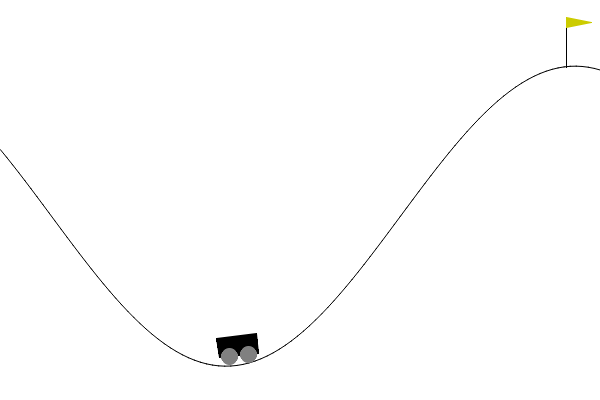

In [3]:
import gymnasium as gym
from PIL import Image

# Create and initialize the MountainCar environment
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env.reset()

# Render the environment's state to a numpy array
frame = env.render()

# Convert the numpy array to an image and display it
image = Image.fromarray(frame)

# Don't forget to close the environment when you're done!
env.close()

display(image)

The mountain car environment provides the following discrete actions:

* 0 - Apply left force
* 1 - Apply no force
* 2 - Apply right force

The mountain car environment is made up of the following continuous values:

* state[0] - Position
* state[1] - Velocity

The cart is not strong enough. It will need to use potential energy from the mountain behind it. The following code shows an agent that applies full throttle to climb the hill.

In [4]:
import gym
import gymnasium as gymnasium
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np

# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# Create Mountain Car environment
env = gymnasium.make('MountainCar-v0', render_mode="rgb_array")
env.metadata['render_fps'] = 30
# Reset the environment
env.reset()

# Setup the wrapper to record the video
video_callable=lambda episode_id: True
env = RecordVideo(env, video_folder='./videos', episode_trigger=video_callable)

# Run the environment until done

truncated = False
i=0
while not truncated:
  i+=1
  action = 2
  state, reward, terminated, truncated , info = env.step(action)
  print(f"Step {i}: State={state}, Reward={reward}, term={terminated}, trunc={truncated}, info={info}")

env.close()

# Display the video
video = io.open(glob.glob('videos/*.mp4')[0], 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
'''.format(encoded.decode('ascii'))))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Step 1: State=[-0.51047415  0.0009084 ], Reward=-1.0, term=False, trunc=False, info={}
Step 2: State=[-0.5086642   0.00180999], Reward=-1.0, term=False, trunc=False, info={}
Step 3: State=[-0.5059661   0.00269802], Reward=-1.0, term=False, trunc=False, info={}
Step 4: State=[-0.50240034  0.00356583], Reward=-1.0, term=False, trunc=False, info={}
Step 5: State=[-0.49799338  0.00440695], Reward=-1.0, term=False, trunc=False, info={}
Step 6: State=[-0.49277827  0.0052151 ], Reward=-1.0, term=False, trunc=False, info={}
Step 7: State=[-0.486794    0.00598428], Reward=-1.0, term=False, trunc=False, info={}
Step 8: State=[-0.4800852  0.0067088], Reward=-1.0, term=False, trunc=False, info={}
Step 9: State=[-0.47270182  0.00738338], Reward=-1.0, term=False, trunc=False, info={}
Step 10: State=[-0.46469867  0.00800313], Reward=-1.0, term=False, trunc=False, info={}
Step 11: State=[-0.456135    0.00856367], Reward=-1.0, term=False, trunc=False, info={}
Step 12: State=[-0.44707385  0.00906114], R

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Step 200: State=[-0.2837191  -0.00625771], Reward=-1.0, term=False, trunc=True, info={}


## Programmed Car

Now we will look at a car that I hand-programmed. This car is straightforward; however, it solves the problem. The programmed car always applies force in one direction or another. It does not break. Whatever direction the vehicle is currently rolling, the agent uses power in that direction. Therefore, the car begins to climb a hill, is overpowered, and turns backward. However, once it starts to roll backward, force is immediately applied in this new direction.

The following code implements this preprogrammed car.

In [5]:
import gym
import gymnasium as gymnasium
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np

# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# Create Mountain Car environment
env = gymnasium.make('MountainCar-v0', render_mode="rgb_array")
env.metadata['render_fps'] = 30
# Reset the environment
env.reset()

# Setup the wrapper to record the video
video_callable=lambda episode_id: True
env = RecordVideo(env, video_folder='./videos', episode_trigger=video_callable)

# Run the environment until done

truncated = False
i=0
action = 2
while not truncated:
  i+=1
  state, reward, terminated, truncated , info = env.step(action)
  print(f"Step {i}: State={state}, Reward={reward}, term={terminated}, trunc={truncated}, info={info}")
  if state[1] > 0:
    action = 2
  else:
    action = 0

env.close()

# Display the video
video = io.open(glob.glob('videos/*.mp4')[0], 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
'''.format(encoded.decode('ascii'))))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Step 1: State=[-0.5504664   0.00121034], Reward=-1.0, term=False, trunc=False, info={}
Step 2: State=[-0.5480548   0.00241163], Reward=-1.0, term=False, trunc=False, info={}
Step 3: State=[-0.54445994  0.00359488], Reward=-1.0, term=False, trunc=False, info={}
Step 4: State=[-0.5397087   0.00475124], Reward=-1.0, term=False, trunc=False, info={}
Step 5: State=[-0.53383666  0.00587201], Reward=-1.0, term=False, trunc=False, info={}
Step 6: State=[-0.5268879   0.00694879], Reward=-1.0, term=False, trunc=False, info={}
Step 7: State=[-0.5189144   0.00797345], Reward=-1.0, term=False, trunc=False, info={}
Step 8: State=[-0.5099761   0.00893832], Reward=-1.0, term=False, trunc=False, info={}
Step 9: State=[-0.50013995  0.00983618], Reward=-1.0, term=False, trunc=False, info={}
Step 10: State=[-0.48947954  0.01066039], Reward=-1.0, term=False, trunc=False, info={}
Step 11: State=[-0.4780746   0.01140494], Reward=-1.0, term=False, trunc=False, info={}
Step 12: State=[-0.46601003  0.01206457],

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Step 115: State=[0.5059111  0.04944082], Reward=-1.0, term=True, trunc=False, info={}
Step 116: State=[0.5562193  0.05030822], Reward=-1.0, term=True, trunc=False, info={}
Step 117: State=[0.6        0.05155249], Reward=-1.0, term=True, trunc=False, info={}
Step 118: State=[0.6        0.05312049], Reward=-1.0, term=True, trunc=False, info={}
Step 119: State=[0.6        0.05468849], Reward=-1.0, term=True, trunc=False, info={}
Step 120: State=[0.6       0.0562565], Reward=-1.0, term=True, trunc=False, info={}
Step 121: State=[0.6       0.0578245], Reward=-1.0, term=True, trunc=False, info={}
Step 122: State=[0.6        0.05939251], Reward=-1.0, term=True, trunc=False, info={}
Step 123: State=[0.6        0.06096052], Reward=-1.0, term=True, trunc=False, info={}
Step 124: State=[0.6        0.06252852], Reward=-1.0, term=True, trunc=False, info={}
Step 125: State=[0.6        0.06409653], Reward=-1.0, term=True, t

### Reinforcement Learning

Q-Learning is a system of rewards that the algorithm gives an agent for successfully moving the environment into a state considered successful. These rewards are the Q-values from which this algorithm takes its name. The final output from the Q-Learning algorithm is a table of Q-values that indicate the reward value of every action that the agent can take, given every possible environment state. The agent must bin continuous state values into a fixed finite number of columns.

Learning occurs when the algorithm runs the agent and environment through episodes and updates the Q-values based on the rewards received from actions taken; Figure 12.REINF provides a high-level overview of this reinforcement or Q-Learning loop.

**Figure 12.REINF:Reinforcement/Q Learning**
![Reinforcement Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/reinforcement.png "Reinforcement Learning")

The Q-values can dictate action by selecting the action column with the highest Q-value for the current environment state. The choice between choosing a random action and a Q-value-driven action is governed by the epsilon ($\epsilon$) parameter, the probability of random action.

Each time through the training loop, the training algorithm updates the Q-values according to the following equation.


$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{old value}} \bigg) }^{\text{temporal difference}}$

There are several parameters in this equation:
* alpha ($\alpha$) - The learning rate, how much should the current step cause the Q-values to be updated.
* lambda ($\lambda$) - The discount factor is the percentage of future reward that the algorithm should consider in this update.

This equation modifies several values:

* $Q(s_t,a_t)$ - The Q-table.  For each combination of states, what reward would the agent likely receive for performing each action?
* $s_t$ - The current state.
* $r_t$ - The last reward received.
* $a_t$ - The action that the agent will perform.

The equation works by calculating a delta (temporal difference) that the equation should apply to the old state. This learning rate ($\alpha$) scales this delta. A learning rate of 1.0 would fully implement the temporal difference in the Q-values each iteration and would likely be very chaotic.

There are two parts to the temporal difference: the new and old values. The new value is subtracted from the old value to provide a delta; the full amount we would change the Q-value by if the learning rate did not scale this value. The new value is a summation of the reward received from the last action and the maximum Q-values from the resulting state when the client takes this action. Adding the maximum of action Q-values for the new state is essential because it estimates the optimal future values from proceeding with this action.

## Q-Learning Car

We will now use Q-Learning to produce a car that learns to drive itself. Look out, Tesla! We begin by defining two essential functions.


In [6]:
import gymnasium
import numpy as np

# This function converts the floating point state values into
# discrete values. This is often called binning.  We divide
# the range that the state values might occupy and assign
# each region to a bucket.
def calc_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/buckets
    return tuple(discrete_state.astype(int))

# Run one game.  The q_table to use is provided.  We also
# provide a flag to indicate if the game should be
# rendered/animated.  Finally, we also provide
# a flag to indicate if the q_table should be updated.
def run_game(q_table, render, should_update):
    done = False
    discrete_state = calc_discrete_state(env.reset()[0])
    success = False

    while not done:
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action
            # (and probably refine)
            action = np.argmax(q_table[discrete_state])
        else:
            # Explore - t
            action = np.random.randint(0, env.action_space.n)

        # Run simulation step
        new_state, reward, done, _, _ = env.step(action)

        # Convert continuous state to discrete
        new_state_disc = calc_discrete_state(new_state)

        # Have we reached the goal position (have we won?)?
        if new_state[0] >= env.unwrapped.goal_position:
            success = True

        # Update q-table
        if should_update:
            max_future_q = np.max(q_table[new_state_disc])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * \
                (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_state_disc

        if render:
            env.render()

    return success


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Several hyperparameters are very important for Q-Learning. These parameters will likely need adjustment as you apply Q-Learning to other problems. Because of this, it is crucial to understand the role of each parameter.

* **LEARNING_RATE** The rate at which previous Q-values are updated based on new episodes run during training.
* **DISCOUNT** The amount of significance to give estimates of future rewards when added to the reward for the current action taken. A value of 0.95 would indicate a discount of 5% on the future reward estimates.
* **EPISODES** The number of episodes to train over. Increase this for more complex problems; however, training time also increases.
* **SHOW_EVERY** How many episodes to allow to elapse before showing an update.
* **DISCRETE_GRID_SIZE** How many buckets to use when converting each continuous state variable. For example, [10, 10] indicates that the algorithm should use ten buckets for the first and second state variables.
* **START_EPSILON_DECAYING** Epsilon is the probability that the agent will select a random action over what the Q-Table suggests. This value determines the starting probability of randomness.
* **END_EPSILON_DECAYING** How many episodes should elapse before epsilon goes to zero and no random actions are permitted. For example, EPISODES//10  means only the first 1/10th of the episodes might have random actions.

In [7]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 500
SHOW_EVERY = 100

DISCRETE_GRID_SIZE = [10, 10]
START_EPSILON_DECAYING = 0.5
END_EPSILON_DECAYING = EPISODES//10


We can now make the environment.  If we are running in Google COLAB, we wrap the environment to be displayed inside the web browser.  Next, create the discrete buckets for state and build Q-table.

In [8]:
env = gymnasium.make("MountainCar-v0")

epsilon = 1
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
buckets = (env.observation_space.high - env.observation_space.low) \
    / DISCRETE_GRID_SIZE
q_table = np.random.uniform(low=-3, high=0, size=(DISCRETE_GRID_SIZE
                                                  + [env.action_space.n]))
success = False


We can now make the environment.  If we are running in Google COLAB, we wrap the environment to be displayed inside the web browser.  Next, create the discrete buckets for state and build Q-table.

In [9]:
episode = 0
success_count = 0

# Loop through the required number of episodes
while episode < EPISODES:
    episode += 1
    done = False

    # Run the game.  If we are local, display render animation
    # at SHOW_EVERY intervals.
    if episode % SHOW_EVERY == 0:
        print(f"Current episode: {episode}, success: {success_count}" +
              f" {(float(success_count)/SHOW_EVERY)}")
        success = run_game(q_table, True, False)
        success_count = 0
    else:
        success = run_game(q_table, False, True)

    # Count successes
    if success:
        success_count += 1

    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)

print(success)


Current episode: 100, success: 99 0.99


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/mountain_car.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


Current episode: 200, success: 100 1.0
Current episode: 300, success: 100 1.0
Current episode: 400, success: 100 1.0
Current episode: 500, success: 100 1.0
True


As you can see, the number of successful episodes generally increases as training progresses. It is not advisable to stop the first time we observe 100% success over 1,000 episodes. There is a randomness to most games, so it is not likely that an agent would retain its 100% success rate with a new run. It might be safe to stop training once you observe that the agent has gotten 100% for several update intervals.

## Running and Observing the Agent

Now that the algorithm has trained the agent, we can observe the agent in action. You can use the following code to see the agent in action.

In [14]:
# HIDE OUTPUT

# Setup the wrapper to record the video
env = gymnasium.make("MountainCar-v0", render_mode="rgb_array")
video_callable=lambda episode_id: True
env = RecordVideo(env, video_folder='./videos', episode_trigger=video_callable)

run_game(q_table, True, False)

# Display the video
video = io.open(glob.glob('videos/*.mp4')[0], 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
'''.format(encoded.decode('ascii'))))


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


## Inspecting the Q-Table

We can also display the Q-table. The following code shows the agent's action for each environment state. As the weights of a neural network, this table is not straightforward to interpret. Some patterns do emerge in that direction, as seen by calculating the means of rows and columns. The actions seem consistent at both velocity and position's upper and lower halves.

In [11]:
import pandas as pd

df = pd.DataFrame(q_table.argmax(axis=2))

df.columns = [f'v-{x}' for x in range(DISCRETE_GRID_SIZE[0])]
df.index = [f'p-{x}' for x in range(DISCRETE_GRID_SIZE[1])]
df


,v-0,v-1,v-2,v-3,v-4,v-5,v-6,v-7,v-8,v-9
p-0,2,2,0,1,2,2,2,0,2,1
p-1,2,0,0,2,0,0,0,2,2,0
p-2,2,2,1,2,1,2,2,1,2,1
p-3,1,0,1,0,2,2,2,1,2,1
p-4,1,0,0,2,0,2,2,2,2,0
p-5,1,1,0,0,1,2,1,2,2,0
p-6,2,1,0,0,0,0,2,2,2,2
p-7,0,2,2,1,0,2,2,1,1,0
p-8,0,1,1,1,0,2,1,2,1,2
p-9,0,2,0,1,1,1,2,1,0,2


In [12]:
df.mean(axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


v-0    1.1
v-1    1.1
v-2    0.5
v-3    1.0
v-4    0.7
v-5    1.5
v-6    1.6
v-7    1.4
v-8    1.6
v-9    0.9
dtype: float64

In [13]:
df.mean(axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


p-0    1.4
p-1    0.8
p-2    1.6
p-3    1.2
p-4    1.1
p-5    1.0
p-6    1.1
p-7    1.1
p-8    1.1
p-9    1.0
dtype: float64